# MPO Training for LIGO ASC Environment with Seismic Noise

This notebook implements Maximum a Posteriori Policy Optimization (MPO) training for the LIGO Angular Sensing and Control (ASC) environment with enhanced seismic noise observations.

## Features:
- **Enhanced Observation Space**: 15-dimensional states including seismic information
- **MPO Algorithm**: Advanced policy optimization with uncertainty quantification  
- **Realistic Disturbances**: Real LIGO O3 noise characteristics
- **Custom Reward Function**: User-defined reward structure for ASC objectives
- **Comprehensive Evaluation**: Training monitoring and rollout analysis

## 1. Import Required Libraries

In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import os
import time
from collections import deque, defaultdict

# Deep learning and RL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, MultivariateNormal
import gymnasium as gym

# LIGO ASC Environment
import sys
sys.path.append('/Users/arushpimpalkar/work/timepass/RL_Arush/src')
# LIGOASCEnvEnhanced will be defined in a later cell

# Signal processing
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Libraries imported successfully!
PyTorch version: 2.9.1
CUDA available: False


## 2. Create Enhanced ASC Environment with Seismic States

First, we need to create the enhanced environment class that includes seismic noise in the observation space.

In [2]:
# Enhanced LIGO ASC Environment with Seismic Observations
import gymnasium as gym
from gymnasium import spaces
from rl_arush.envs.ligo_asc_env import LIGOASCEnv

class LIGOASCEnvEnhanced(LIGOASCEnv):
    """Enhanced LIGO ASC Environment with seismic noise in observation space."""
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        # Seismic band filters for observation enhancement
        nyq = self.fs_ctrl / 2
        self.seismic_low_sos = signal.butter(2, [0.1/nyq, 1/nyq], btype='band', output='sos')
        self.seismic_mid_sos = signal.butter(2, [1/nyq, 8/nyq], btype='band', output='sos') 
        self.seismic_high_sos = signal.butter(2, [8/nyq, min(30/nyq, 0.99)], btype='band', output='sos')
        
        # Seismic filter states
        self.seismic_low_state = np.zeros((self.seismic_low_sos.shape[0], 2))
        self.seismic_mid_state = np.zeros((self.seismic_mid_sos.shape[0], 2))
        self.seismic_high_state = np.zeros((self.seismic_high_sos.shape[0], 2))
        
        # Seismic history
        self.prev_seismic = 0.0
        self.prev_seismic_vel = 0.0
        self.seismic_window = []
        self.seismic_window_size = 32  # 32 samples @ 256 Hz = 0.125 sec
        
        # Update observation space to include 7 seismic features
        obs_dim = 15  # 8 original + 7 seismic
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        
        print(f"Enhanced environment created with {obs_dim}-dimensional observation space")
    
    def _get_observation(self) -> np.ndarray:
        """Enhanced observation including seismic information."""
        
        # Original observation components
        base_obs = np.array([
            self.error_history[0] * 1e6,     # [0] Current pitch error [µrad]
            self.error_history[1] * 1e6,     # [1] Previous pitch error [µrad]
            self.filtered_error_obs * 1e6,   # [2] Observation band error [µrad]
            self.filtered_error_ctrl * 1e6,  # [3] Control band error [µrad]
            self.control_history[0],         # [4] Current control [-1,1]
            self.control_history[1],         # [5] Previous control [-1,1]
            self.control_history[2],         # [6] Control t-2 [-1,1]
            self.control_history[3],         # [7] Control t-3 [-1,1]
        ])
        
        # Seismic information
        current_seismic = self.seismic_noise[self.noise_index]
        
        # Apply seismic filters
        seismic_low, self.seismic_low_state = signal.sosfilt(
            self.seismic_low_sos, [current_seismic], zi=self.seismic_low_state)
        seismic_mid, self.seismic_mid_state = signal.sosfilt(
            self.seismic_mid_sos, [current_seismic], zi=self.seismic_mid_state)
        seismic_high, self.seismic_high_state = signal.sosfilt(
            self.seismic_high_sos, [current_seismic], zi=self.seismic_high_state)
        
        # Seismic derivatives (velocity/acceleration)
        seismic_velocity = current_seismic - self.prev_seismic
        seismic_accel = seismic_velocity - self.prev_seismic_vel
        
        # Update history
        self.prev_seismic = current_seismic
        self.prev_seismic_vel = seismic_velocity
        
        # Seismic statistics
        self.seismic_window.append(current_seismic)
        if len(self.seismic_window) > self.seismic_window_size:
            self.seismic_window.pop(0)
        seismic_rms = np.sqrt(np.mean([s**2 for s in self.seismic_window])) if self.seismic_window else 0.0
        
        # Enhanced observation vector
        seismic_obs = np.array([
            current_seismic * 1e6,           # [8] Raw seismic force [µN] 
            seismic_low[0] * 1e6,           # [9] Low freq seismic [µN]
            seismic_mid[0] * 1e6,           # [10] Mid freq seismic [µN] 
            seismic_high[0] * 1e6,          # [11] High freq seismic [µN]
            seismic_velocity * 1e6,         # [12] Seismic velocity [µN/s]
            seismic_accel * 1e6,            # [13] Seismic acceleration [µN/s²]
            seismic_rms * 1e6,              # [14] Seismic RMS [µN]
        ])
        
        return np.concatenate([base_obs, seismic_obs]).astype(np.float32)
    
    def _reset_state(self):
        """Reset environment state including seismic filters."""
        super()._reset_state()
        
        # Reset seismic filter states
        self.seismic_low_state = np.zeros((self.seismic_low_sos.shape[0], 2))
        self.seismic_mid_state = np.zeros((self.seismic_mid_sos.shape[0], 2))
        self.seismic_high_state = np.zeros((self.seismic_high_sos.shape[0], 2))
        
        # Reset seismic history
        self.prev_seismic = 0.0
        self.prev_seismic_vel = 0.0
        self.seismic_window = []

In [3]:
# Test the enhanced environment
try:
    env = LIGOASCEnvEnhanced()
    obs, info = env.reset()
    print(f"Environment created successfully!")
    print(f"Observation space: {env.observation_space}")
    print(f"Action space: {env.action_space}")
    print(f"Initial observation shape: {obs.shape}")
    print(f"Initial observation:\n{obs}")
    
    # Test a few steps
    for i in range(3):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        print(f"Step {i+1}: obs_shape={obs.shape}, reward={reward:.3f}")
        
except Exception as e:
    print(f"Error creating environment: {e}")
    print("Falling back to original environment for now...")
    # Fallback to original environment if enhanced version has issues
    from rl_arush.envs.ligo_asc_env import LIGOASCEnv
    env = LIGOASCEnv()
    obs, info = env.reset()
    print(f"Original environment loaded with observation shape: {obs.shape}")

Error creating environment: 'LIGOASCEnvEnhanced' object has no attribute 'seismic_low_sos'
Falling back to original environment for now...
Original environment loaded with observation shape: (8,)


## 3. MPO (Maximum a Posteriori Policy Optimization) Implementation

In [4]:
class PolicyNetwork(nn.Module):
    """Policy network for continuous control."""
    
    def __init__(self, obs_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Mean and log_std heads
        self.mean_head = nn.Linear(hidden_dim, action_dim)
        self.log_std_head = nn.Linear(hidden_dim, action_dim)
        
        # Initialize parameters
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.orthogonal_(m.weight, gain=0.01)
            nn.init.constant_(m.bias, 0)
    
    def forward(self, obs):
        features = self.shared(obs)
        mean = self.mean_head(features)
        log_std = self.log_std_head(features)
        log_std = torch.clamp(log_std, -20, 2)  # Prevent numerical issues
        
        return mean, log_std
    
    def sample(self, obs):
        mean, log_std = self.forward(obs)
        std = torch.exp(log_std)
        dist = Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        
        return action, log_prob
    
    def log_prob(self, obs, action):
        mean, log_std = self.forward(obs)
        std = torch.exp(log_std)
        dist = Normal(mean, std)
        return dist.log_prob(action).sum(dim=-1)


class ValueNetwork(nn.Module):
    """Value network for state value estimation."""
    
    def __init__(self, obs_dim, hidden_dim=256):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.orthogonal_(m.weight, gain=1.0)
            nn.init.constant_(m.bias, 0)
    
    def forward(self, obs):
        return self.network(obs).squeeze(-1)


class QNetwork(nn.Module):
    """Q-network for action-value estimation."""
    
    def __init__(self, obs_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.orthogonal_(m.weight, gain=1.0)
            nn.init.constant_(m.bias, 0)
    
    def forward(self, obs, action):
        x = torch.cat([obs, action], dim=-1)
        return self.network(x).squeeze(-1)

In [5]:
class MPOAgent:
    """Maximum a Posteriori Policy Optimization Agent."""
    
    def __init__(self, obs_dim, action_dim, lr=3e-4, gamma=0.99, tau=0.005, 
                 epsilon=0.1, temperature=0.1, device='cpu'):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon  # KL constraint
        self.temperature = temperature
        self.device = device
        
        # Networks
        self.policy = PolicyNetwork(obs_dim, action_dim).to(device)
        self.value = ValueNetwork(obs_dim).to(device)
        self.q1 = QNetwork(obs_dim, action_dim).to(device)
        self.q2 = QNetwork(obs_dim, action_dim).to(device)
        
        # Target networks
        self.target_value = ValueNetwork(obs_dim).to(device)
        self.target_q1 = QNetwork(obs_dim, action_dim).to(device)
        self.target_q2 = QNetwork(obs_dim, action_dim).to(device)
        
        # Copy parameters to target networks
        self.hard_update(self.target_value, self.value)
        self.hard_update(self.target_q1, self.q1)
        self.hard_update(self.target_q2, self.q2)
        
        # Optimizers
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)
        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=lr)
        
        # Lagrange multipliers for MPO constraints
        self.log_eta = torch.tensor(1.0, requires_grad=True, device=device)
        self.log_alpha_mu = torch.tensor(1.0, requires_grad=True, device=device)
        self.log_alpha_sigma = torch.tensor(1.0, requires_grad=True, device=device)
        
        self.dual_optimizer = optim.Adam([self.log_eta, self.log_alpha_mu, self.log_alpha_sigma], lr=lr)
        
    def hard_update(self, target, source):
        """Hard update of target network parameters."""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
    
    def soft_update(self, target, source):
        """Soft update of target network parameters."""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)
    
    def select_action(self, obs, deterministic=False):
        """Select action from policy."""
        obs = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            if deterministic:
                mean, _ = self.policy(obs)
                action = mean
            else:
                action, _ = self.policy.sample(obs)
                
        return action.cpu().numpy().flatten()
    
    def update(self, batch):
        """Update all networks using MPO algorithm."""
        states, actions, rewards, next_states, dones = batch
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Update Q-functions
        q1_loss, q2_loss = self.update_q_functions(states, actions, rewards, next_states, dones)
        
        # Update Value function
        value_loss = self.update_value_function(states, actions)
        
        # Update Policy using MPO
        policy_loss, kl_div = self.update_policy_mpo(states, actions)
        
        # Update dual variables
        self.update_dual_variables(kl_div)
        
        # Soft update target networks
        self.soft_update(self.target_value, self.value)
        self.soft_update(self.target_q1, self.q1)
        self.soft_update(self.target_q2, self.q2)
        
        return {
            'q1_loss': q1_loss.item(),
            'q2_loss': q2_loss.item(),
            'value_loss': value_loss.item(),
            'policy_loss': policy_loss.item(),
            'kl_div': kl_div.item(),
            'eta': torch.exp(self.log_eta).item(),
            'alpha_mu': torch.exp(self.log_alpha_mu).item(),
            'alpha_sigma': torch.exp(self.log_alpha_sigma).item()
        }
    
    def update_q_functions(self, states, actions, rewards, next_states, dones):
        """Update Q-functions."""
        with torch.no_grad():
            next_values = self.target_value(next_states)
            targets = rewards + self.gamma * (1 - dones) * next_values
        
        q1_pred = self.q1(states, actions)
        q2_pred = self.q2(states, actions)
        
        q1_loss = F.mse_loss(q1_pred, targets)
        q2_loss = F.mse_loss(q2_pred, targets)
        
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()
        
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()
        
        return q1_loss, q2_loss
    
    def update_value_function(self, states, actions):
        """Update value function."""
        with torch.no_grad():
            q1_values = self.target_q1(states, actions)
            q2_values = self.target_q2(states, actions)
            q_values = torch.min(q1_values, q2_values)
        
        value_pred = self.value(states)
        value_loss = F.mse_loss(value_pred, q_values)
        
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        return value_loss
    
    def update_policy_mpo(self, states, actions):
        """Update policy using MPO objective."""
        # Compute advantages
        with torch.no_grad():
            q1_values = self.q1(states, actions)
            q2_values = self.q2(states, actions)
            q_values = torch.min(q1_values, q2_values)
            values = self.value(states)
            advantages = q_values - values
        
        # Temperature-scaled advantages
        eta = torch.exp(self.log_eta)
        scaled_advantages = advantages / eta
        
        # Importance weights
        weights = F.softmax(scaled_advantages, dim=0)
        
        # Policy log probabilities
        log_probs = self.policy.log_prob(states, actions)
        
        # MPO policy loss
        weighted_log_probs = weights.detach() * log_probs
        policy_loss = -weighted_log_probs.sum()
        
        # KL divergence for constraint
        kl_div = F.kl_div(log_probs, weights, reduction='sum')
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        
        return policy_loss, kl_div
    
    def update_dual_variables(self, kl_div):
        """Update Lagrange multipliers."""
        eta_loss = torch.exp(self.log_eta) * (self.epsilon - kl_div.detach())
        
        self.dual_optimizer.zero_grad()
        eta_loss.backward()
        self.dual_optimizer.step()
        
        # Clamp dual variables
        with torch.no_grad():
            self.log_eta.clamp_(-10, 10)
            self.log_alpha_mu.clamp_(-10, 10)
            self.log_alpha_sigma.clamp_(-10, 10)

## 4. Initialize MPO Agent and Environment

In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create environment
try:
    env = LIGOASCEnvEnhanced()
    print("Enhanced environment with seismic states created successfully!")
except:
    print("Falling back to original environment...")
    from rl_arush.envs.ligo_asc_env import LIGOASCEnv
    env = LIGOASCEnv()

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(f"Environment specs:")
print(f"  Observation dimension: {obs_dim}")
print(f"  Action dimension: {action_dim}")
print(f"  Observation space: {env.observation_space}")
print(f"  Action space: {env.action_space}")

# MPO Hyperparameters
mpo_config = {
    'lr': 3e-4,
    'gamma': 0.995,
    'tau': 0.005,
    'epsilon': 0.1,      # KL constraint for MPO
    'temperature': 0.1,  # Temperature for advantage scaling
    'device': device
}

# Initialize MPO agent
agent = MPOAgent(obs_dim, action_dim, **mpo_config)
print(f"\nMPO Agent initialized with configuration:")
for key, value in mpo_config.items():
    print(f"  {key}: {value}")

# Test agent action selection
obs, _ = env.reset()
action = agent.select_action(obs)
print(f"\nTest action selection:")
print(f"  Observation shape: {obs.shape}")
print(f"  Action shape: {action.shape}")
print(f"  Action: {action}")

Using device: cpu
Falling back to original environment...
Environment specs:
  Observation dimension: 8
  Action dimension: 1
  Observation space: Box(-inf, inf, (8,), float32)
  Action space: Box(-1.0, 1.0, (1,), float32)

MPO Agent initialized with configuration:
  lr: 0.0003
  gamma: 0.995
  tau: 0.005
  epsilon: 0.1
  temperature: 0.1
  device: cpu

Test action selection:
  Observation shape: (8,)
  Action shape: (1,)
  Action: [0.8962122]


## 5. Placeholder for Custom Reward Function

**USER TODO**: Implement your custom reward function here. The template below shows the standard structure.

In [7]:
class CustomRewardWrapper(gym.Wrapper):
    """
    Frequency-band based reward wrapper for LIGO ASC environment.
    
    Computes reward as the product of sigmoid scores for three frequency bands:
    - Low band: < 3 Hz (seismic, tilt)
    - Mid band: 8-30 Hz (machinery, traffic)  
    - High band: > 40 Hz (local vibrations, electronics)
    
    Each band gets a sigmoid score based on its power spectral density,
    with lower power yielding higher scores (better performance).
    """
    
    def __init__(self, env):
        super().__init__(env)
        # Initialize error buffer for frequency analysis
        self.error_buffer = deque(maxlen=512)  # ~2 seconds at 256 Hz
        self.fs = 256  # Sample rate
        
    def reward(self, obs, action, info):
        """
        Frequency-band based reward function using sigmoid scores.
        
        Args:
            obs: Current observation (15-dim if enhanced, 8-dim if basic)
            action: Applied action
            info: Environment info dict
            
        Returns:
            reward: Float reward value (product of sigmoid scores)
        """
        
        # Initialize error history buffer if not exists
        if not hasattr(self, 'error_buffer'):
            self.error_buffer = deque(maxlen=512)  # ~2 seconds at 256 Hz
            self.fs = 256  # Sample rate
        
        # Extract current pitch error (in microradians)
        current_pitch_error = obs[0]  # Current pitch error [µrad]
        self.error_buffer.append(current_pitch_error)
        
        # Need sufficient data for frequency analysis
        if len(self.error_buffer) < 256:
            # Return simple error-based reward during initial accumulation
            return -np.abs(current_pitch_error) / 1000.0
        
        # Convert to numpy array and compute power spectral density
        error_signal = np.array(self.error_buffer)
        freqs = np.fft.fftfreq(len(error_signal), 1/self.fs)
        fft_signal = np.fft.fft(error_signal)
        psd = np.abs(fft_signal)**2
        
        # Only use positive frequencies
        positive_mask = freqs > 0
        freqs = freqs[positive_mask]
        psd = psd[positive_mask]
        
        # Define frequency bands
        low_band_mask = freqs < 3.0      # Low: < 3 Hz
        mid_band_mask = (freqs >= 8.0) & (freqs <= 30.0)  # Mid: 8-30 Hz
        high_band_mask = freqs > 40.0    # High: > 40 Hz
        
        # Calculate power in each band (normalize by number of frequency bins)
        low_power = np.sum(psd[low_band_mask]) / max(1, np.sum(low_band_mask))
        mid_power = np.sum(psd[mid_band_mask]) / max(1, np.sum(mid_band_mask))
        high_power = np.sum(psd[high_band_mask]) / max(1, np.sum(high_band_mask))
        
        # Convert to log scale to handle wide dynamic range
        low_log = np.log10(max(low_power, 1e-10))
        mid_log = np.log10(max(mid_power, 1e-10))
        high_log = np.log10(max(high_power, 1e-10))
        
        # Apply sigmoid function to convert to [0,1] scores
        # Lower power = higher score (better performance)
        # Adjust scale factors for each band based on typical LIGO requirements
        low_score = 1 / (1 + np.exp((low_log + 6) * 2))    # Target: ~1e-6 µrad²/Hz
        mid_score = 1 / (1 + np.exp((mid_log + 8) * 2))    # Target: ~1e-8 µrad²/Hz  
        high_score = 1 / (1 + np.exp((high_log + 10) * 2)) # Target: ~1e-10 µrad²/Hz
        
        # Multiply all sigmoid scores together
        reward = low_score * mid_score * high_score
        
        # Add small control effort penalty to prevent excessive actuator usage
        control_effort = action[0] if hasattr(action, '__len__') else action
        control_penalty = 0.01 * abs(control_effort)
        
        final_reward = reward * (1 - control_penalty)
        
        return final_reward
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Replace reward with custom reward
        custom_reward = self.reward(obs, action, info)
        
        return obs, custom_reward, terminated, truncated, info

# Create wrapped environment with custom frequency-band reward
env = CustomRewardWrapper(env)  # Now using custom frequency-band reward
print("Custom frequency-band reward function implemented and activated!")
print("Reward = sigmoid_low * sigmoid_mid * sigmoid_high * (1 - control_penalty)")
print("Frequency bands: Low (<3Hz), Mid (8-30Hz), High (>40Hz)")

Custom frequency-band reward function implemented and activated!
Reward = sigmoid_low * sigmoid_mid * sigmoid_high * (1 - control_penalty)
Frequency bands: Low (<3Hz), Mid (8-30Hz), High (>40Hz)


## 6. Experience Buffer and Training Utilities

In [8]:
class ReplayBuffer:
    """Experience replay buffer for MPO training."""
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        """Add experience to buffer."""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """Sample batch of experiences."""
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        
        for idx in batch:
            state, action, reward, next_state, done = self.buffer[idx]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
        return (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(dones))
    
    def __len__(self):
        return len(self.buffer)


def collect_episode(env, agent, max_steps=1000, render=False):
    """Collect one episode of experience."""
    obs, _ = env.reset()
    episode_reward = 0
    episode_length = 0
    experiences = []
    
    for step in range(max_steps):
        action = agent.select_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        experiences.append((obs, action, reward, next_obs, terminated))
        
        episode_reward += reward
        episode_length += 1
        obs = next_obs
        
        if terminated or truncated:
            break
            
    return experiences, episode_reward, episode_length


def evaluate_policy(env, agent, num_episodes=5, max_steps=1000, deterministic=True):
    """Evaluate policy performance."""
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        
        for step in range(max_steps):
            action = agent.select_action(obs, deterministic=deterministic)
            obs, reward, terminated, truncated, _ = env.step(action)
            
            episode_reward += reward
            episode_length += 1
            
            if terminated or truncated:
                break
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
    
    return {
        'mean_reward': np.mean(episode_rewards),
        'std_reward': np.std(episode_rewards),
        'mean_length': np.mean(episode_lengths),
        'rewards': episode_rewards
    }


# Initialize training components
buffer_size = 100000
batch_size = 256
replay_buffer = ReplayBuffer(buffer_size)

print(f"Training components initialized:")
print(f"  Replay buffer capacity: {buffer_size}")
print(f"  Batch size: {batch_size}")

Training components initialized:
  Replay buffer capacity: 100000
  Batch size: 256


## 7. Training Loop Implementation

In [9]:
def train_mpo_agent(env, agent, replay_buffer, num_episodes=1000, 
                    warmup_episodes=50, eval_every=50, save_every=100):
    """Main training loop for MPO agent."""
    
    # Training metrics
    training_metrics = {
        'episode_rewards': [],
        'episode_lengths': [],
        'eval_rewards': [],
        'loss_metrics': defaultdict(list)
    }
    
    print("Starting MPO training...")
    print(f"Total episodes: {num_episodes}")
    print(f"Warmup episodes: {warmup_episodes}")
    print(f"Evaluation every: {eval_every} episodes")
    print("-" * 60)
    
    for episode in tqdm(range(num_episodes), desc="Training"):
        # Collect episode experience
        experiences, episode_reward, episode_length = collect_episode(env, agent)
        
        # Add experiences to replay buffer
        for exp in experiences:
            replay_buffer.push(*exp)
        
        # Record metrics
        training_metrics['episode_rewards'].append(episode_reward)
        training_metrics['episode_lengths'].append(episode_length)
        
        # Update agent after warmup
        if episode >= warmup_episodes and len(replay_buffer) >= batch_size:
            # Sample batch and update
            batch = replay_buffer.sample(batch_size)
            loss_metrics = agent.update(batch)
            
            # Record loss metrics
            for key, value in loss_metrics.items():
                training_metrics['loss_metrics'][key].append(value)
        
        # Evaluation
        if (episode + 1) % eval_every == 0:
            eval_results = evaluate_policy(env, agent, num_episodes=5)
            training_metrics['eval_rewards'].append(eval_results['mean_reward'])
            
            print(f"\nEpisode {episode + 1}:")
            print(f"  Train reward (last 50): {np.mean(training_metrics['episode_rewards'][-50:]):.3f}")
            print(f"  Eval reward: {eval_results['mean_reward']:.3f} ± {eval_results['std_reward']:.3f}")
            if len(training_metrics['loss_metrics']['policy_loss']) > 0:
                print(f"  Policy loss: {np.mean(training_metrics['loss_metrics']['policy_loss'][-50:]):.4f}")
                print(f"  Value loss: {np.mean(training_metrics['loss_metrics']['value_loss'][-50:]):.4f}")
        
        # Save checkpoint
        if (episode + 1) % save_every == 0:
            checkpoint_path = f'/Users/arushpimpalkar/work/timepass/RL_Arush/outputs/models/mpo_checkpoint_ep{episode+1}.pkl'
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            
            torch.save({
                'episode': episode,
                'policy_state_dict': agent.policy.state_dict(),
                'value_state_dict': agent.value.state_dict(),
                'q1_state_dict': agent.q1.state_dict(),
                'q2_state_dict': agent.q2.state_dict(),
                'training_metrics': training_metrics,
                'mpo_config': mpo_config
            }, checkpoint_path)
            
            print(f"  Checkpoint saved: {checkpoint_path}")
    
    print("\nTraining completed!")
    return training_metrics


# Training configuration
train_config = {
    'num_episodes': 1000,      # Total training episodes
    'warmup_episodes': 50,     # Episodes before starting updates
    'eval_every': 50,          # Evaluation frequency
    'save_every': 100,         # Checkpoint save frequency
}

print("Training configuration:")
for key, value in train_config.items():
    print(f"  {key}: {value}")
print("\nReady to start training!")
print("Execute the next cell to begin training...")

Training configuration:
  num_episodes: 1000
  warmup_episodes: 50
  eval_every: 50
  save_every: 100

Ready to start training!
Execute the next cell to begin training...


In [10]:
# START TRAINING
training_metrics = train_mpo_agent(env, agent, replay_buffer, **train_config)

print("Training completed successfully!")
print("Check the outputs/models/ directory for saved checkpoints.")

Starting MPO training...
Total episodes: 1000
Warmup episodes: 50
Evaluation every: 50 episodes
------------------------------------------------------------


Training:   9%|▉         | 88/1000 [00:01<00:20, 45.01it/s] 


Episode 50:
  Train reward (last 50): -0.006
  Eval reward: 38.442 ± 44.391


Training:  12%|█▏        | 124/1000 [00:03<00:25, 34.07it/s]


Episode 100:
  Train reward (last 50): 0.000
  Eval reward: 91.611 ± 73.990
  Checkpoint saved: /Users/arushpimpalkar/work/timepass/RL_Arush/outputs/models/mpo_checkpoint_ep100.pkl


Training:  18%|█▊        | 182/1000 [00:04<00:22, 36.10it/s]


Episode 150:
  Train reward (last 50): 0.000
  Eval reward: 8.745 ± 7.140


Training:  21%|██        | 209/1000 [00:05<00:18, 43.58it/s]


Episode 200:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4282
  Value loss: 0.0000
  Checkpoint saved: /Users/arushpimpalkar/work/timepass/RL_Arush/outputs/models/mpo_checkpoint_ep200.pkl


Training:  26%|██▌       | 260/1000 [00:06<00:13, 56.65it/s]


Episode 250:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4476
  Value loss: 0.0000


Training:  31%|███       | 309/1000 [00:07<00:11, 61.06it/s]


Episode 300:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4696
  Value loss: 0.0000
  Checkpoint saved: /Users/arushpimpalkar/work/timepass/RL_Arush/outputs/models/mpo_checkpoint_ep300.pkl


Training:  36%|███▌      | 359/1000 [00:07<00:09, 65.17it/s]


Episode 350:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4608
  Value loss: 0.0000


Training:  41%|████      | 408/1000 [00:08<00:09, 63.82it/s]


Episode 400:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4507
  Value loss: 0.0000
  Checkpoint saved: /Users/arushpimpalkar/work/timepass/RL_Arush/outputs/models/mpo_checkpoint_ep400.pkl


Training:  46%|████▌     | 458/1000 [00:09<00:08, 65.33it/s]


Episode 450:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4595
  Value loss: 0.0000


Training:  51%|█████     | 507/1000 [00:10<00:07, 64.03it/s]


Episode 500:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4483
  Value loss: 0.0000
  Checkpoint saved: /Users/arushpimpalkar/work/timepass/RL_Arush/outputs/models/mpo_checkpoint_ep500.pkl


Training:  56%|█████▌    | 557/1000 [00:10<00:06, 65.43it/s]


Episode 550:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4348
  Value loss: 0.0000


Training:  61%|██████▏   | 613/1000 [00:11<00:05, 64.83it/s]


Episode 600:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4352
  Value loss: 0.0000
  Checkpoint saved: /Users/arushpimpalkar/work/timepass/RL_Arush/outputs/models/mpo_checkpoint_ep600.pkl


Training:  66%|██████▌   | 657/1000 [00:12<00:05, 65.69it/s]


Episode 650:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4266
  Value loss: 0.0000


Training:  71%|███████   | 708/1000 [00:13<00:04, 64.78it/s]


Episode 700:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4247
  Value loss: 0.0000
  Checkpoint saved: /Users/arushpimpalkar/work/timepass/RL_Arush/outputs/models/mpo_checkpoint_ep700.pkl


Training:  76%|███████▌  | 757/1000 [00:13<00:03, 64.85it/s]


Episode 750:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4202
  Value loss: 0.0000


Training:  81%|████████  | 807/1000 [00:14<00:02, 64.59it/s]


Episode 800:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4286
  Value loss: 0.0000
  Checkpoint saved: /Users/arushpimpalkar/work/timepass/RL_Arush/outputs/models/mpo_checkpoint_ep800.pkl


Training:  86%|████████▋ | 863/1000 [00:15<00:02, 64.68it/s]


Episode 850:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4162
  Value loss: 0.0000


Training:  91%|█████████ | 912/1000 [00:16<00:01, 64.14it/s]


Episode 900:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4342
  Value loss: 0.0000
  Checkpoint saved: /Users/arushpimpalkar/work/timepass/RL_Arush/outputs/models/mpo_checkpoint_ep900.pkl


Training:  96%|█████████▌| 962/1000 [00:16<00:00, 65.69it/s]


Episode 950:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4153
  Value loss: 0.0000


Training: 100%|██████████| 1000/1000 [00:17<00:00, 57.22it/s]


Episode 1000:
  Train reward (last 50): 0.000
  Eval reward: 0.000 ± 0.000
  Policy loss: 1.4237
  Value loss: 0.0000
  Checkpoint saved: /Users/arushpimpalkar/work/timepass/RL_Arush/outputs/models/mpo_checkpoint_ep1000.pkl

Training completed!
Training completed successfully!
Check the outputs/models/ directory for saved checkpoints.


## 8. Rollout and Evaluation Functions

In [11]:
def detailed_rollout(env, agent, max_steps=1000, deterministic=True):
    """Perform detailed rollout with full data collection."""
    
    obs, _ = env.reset()
    
    # Data collection
    observations = []
    actions = []
    rewards = []
    pitch_errors = []
    seismic_data = []
    control_signals = []
    
    episode_reward = 0
    
    for step in range(max_steps):
        # Record data
        observations.append(obs.copy())
        
        # Extract specific signals
        pitch_errors.append(obs[0])  # Current pitch error [µrad]
        
        if obs.shape[0] >= 15:  # Enhanced environment
            seismic_data.append(obs[8])  # Raw seismic force [µN]
        else:
            seismic_data.append(0.0)  # No seismic data
        
        # Get action
        action = agent.select_action(obs, deterministic=deterministic)
        actions.append(action.copy())
        control_signals.append(action[0])
        
        # Step environment
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        episode_reward += reward
        
        if terminated or truncated:
            break
    
    return {
        'observations': np.array(observations),
        'actions': np.array(actions),
        'rewards': np.array(rewards),
        'pitch_errors': np.array(pitch_errors),
        'seismic_data': np.array(seismic_data),
        'control_signals': np.array(control_signals),
        'episode_reward': episode_reward,
        'episode_length': len(observations),
        'terminated_naturally': terminated or truncated
    }


def load_trained_agent(checkpoint_path, obs_dim, action_dim):
    """Load trained agent from checkpoint."""
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Recreate agent with saved config
    config = checkpoint['mpo_config']
    agent = MPOAgent(obs_dim, action_dim, **config)
    
    # Load state dicts
    agent.policy.load_state_dict(checkpoint['policy_state_dict'])
    agent.value.load_state_dict(checkpoint['value_state_dict'])
    agent.q1.load_state_dict(checkpoint['q1_state_dict'])
    agent.q2.load_state_dict(checkpoint['q2_state_dict'])
    
    print(f"Agent loaded from episode {checkpoint['episode']}")
    return agent, checkpoint['training_metrics']


def performance_analysis(rollout_data, fs=256):
    """Analyze control performance from rollout data."""
    
    pitch_errors = rollout_data['pitch_errors']
    control_signals = rollout_data['control_signals']
    seismic_data = rollout_data['seismic_data']
    
    # Ensure we have valid data
    if len(pitch_errors) == 0:
        print("Warning: Empty pitch error data")
        return {
            'rms_error_urad': 0.0,
            'max_error_urad': 0.0,
            'control_effort_rms': 0.0,
            'obs_band_power': 0.0,
            'time': np.array([]),
            'frequencies': np.array([]),
            'pitch_psd': np.array([]),
            'episode_reward': rollout_data.get('episode_reward', 0.0)
        }
    
    # Time vector
    time = np.arange(len(pitch_errors)) / fs
    
    # Performance metrics
    rms_error = np.sqrt(np.mean(pitch_errors**2))
    max_error = np.max(np.abs(pitch_errors)) if len(pitch_errors) > 0 else 0.0
    control_effort = np.sqrt(np.mean(control_signals**2)) if len(control_signals) > 0 else 0.0
    
    # Frequency analysis (with minimum length requirement)
    if len(pitch_errors) >= 8:  # Need at least 8 points for meaningful FFT
        freqs = np.fft.fftfreq(len(pitch_errors), 1/fs)
        
        # Compute PSD properly - normalize by frequency resolution
        fft_signal = np.fft.fft(pitch_errors)
        pitch_psd = np.abs(fft_signal)**2 / (fs * len(pitch_errors))
        
        # Debug info for PSD calculation
        print(f"Debug PSD: Length={len(pitch_errors)}, fs={fs}")
        print(f"Debug PSD: PSD range=[{np.min(pitch_psd):.2e}, {np.max(pitch_psd):.2e}]")
        
        # Find observation band (0.1-10 Hz) performance
        obs_mask = (freqs >= 0.1) & (freqs <= 10)
        obs_band_power = np.sum(pitch_psd[obs_mask]) if np.any(obs_mask) else 0.0
    else:
        # Not enough data for FFT
        print(f"Warning: Insufficient data for FFT analysis ({len(pitch_errors)} points)")
        freqs = np.array([])
        pitch_psd = np.array([])
        obs_band_power = 0.0
    
    return {
        'rms_error_urad': rms_error,
        'max_error_urad': max_error,
        'control_effort_rms': control_effort,
        'obs_band_power': obs_band_power,
        'time': time,
        'frequencies': freqs,
        'pitch_psd': pitch_psd,
        'episode_reward': rollout_data['episode_reward']
    }


print("Rollout and evaluation functions defined.")
print("Use detailed_rollout() to collect comprehensive performance data.")
print("Use performance_analysis() to compute control metrics.")

Rollout and evaluation functions defined.
Use detailed_rollout() to collect comprehensive performance data.
Use performance_analysis() to compute control metrics.


## 9. Visualization and Analysis

In [12]:
def plot_training_progress(training_metrics, save_path=None):
    """Plot training progress and metrics."""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Episode rewards
    axes[0, 0].plot(training_metrics['episode_rewards'], alpha=0.7, label='Episode Reward')
    if len(training_metrics['episode_rewards']) > 50:
        # Smoothed curve
        smooth_rewards = pd.Series(training_metrics['episode_rewards']).rolling(50).mean()
        axes[0, 0].plot(smooth_rewards, 'r-', linewidth=2, label='50-episode Moving Average')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Episode Reward')
    axes[0, 0].set_title('Training Rewards')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Evaluation rewards
    eval_episodes = np.arange(0, len(training_metrics['eval_rewards'])) * 50
    axes[0, 1].plot(eval_episodes, training_metrics['eval_rewards'], 'g-o', markersize=4)
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Evaluation Reward')
    axes[0, 1].set_title('Evaluation Performance')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Loss metrics
    if 'policy_loss' in training_metrics['loss_metrics']:
        axes[1, 0].plot(training_metrics['loss_metrics']['policy_loss'], label='Policy Loss')
        axes[1, 0].plot(training_metrics['loss_metrics']['value_loss'], label='Value Loss')
        axes[1, 0].set_xlabel('Update Step')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].set_title('Training Losses')
        axes[1, 0].legend()
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
    
    # MPO specific metrics
    if 'eta' in training_metrics['loss_metrics']:
        axes[1, 1].plot(training_metrics['loss_metrics']['eta'], label='η (Temperature)')
        axes[1, 1].plot(training_metrics['loss_metrics']['alpha_mu'], label='α_μ')
        axes[1, 1].plot(training_metrics['loss_metrics']['alpha_sigma'], label='α_σ')
        axes[1, 1].set_xlabel('Update Step')
        axes[1, 1].set_ylabel('Dual Variable Value')
        axes[1, 1].set_title('MPO Dual Variables')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training progress plot saved to: {save_path}")
    
    plt.show()


def plot_control_performance(rollout_data, analysis_results, save_path=None):
    """Plot detailed control performance analysis."""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    time = analysis_results['time']
    
    # Pitch error time series
    axes[0, 0].plot(time, rollout_data['pitch_errors'], 'b-', linewidth=1)
    axes[0, 0].set_xlabel('Time [s]')
    axes[0, 0].set_ylabel('Pitch Error [µrad]')
    axes[0, 0].set_title(f'Pitch Error (RMS: {analysis_results["rms_error_urad"]:.2f} µrad)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Control signal
    axes[0, 1].plot(time, rollout_data['control_signals'], 'r-', linewidth=1)
    axes[0, 1].set_xlabel('Time [s]')
    axes[0, 1].set_ylabel('Control Signal [-1, 1]')
    axes[0, 1].set_title(f'Control Effort (RMS: {analysis_results["control_effort_rms"]:.3f})')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Pitch error PSD
    freqs = analysis_results['frequencies']
    psd = analysis_results['pitch_psd']
    positive_freqs = freqs > 0
    
    axes[1, 0].loglog(freqs[positive_freqs], psd[positive_freqs], 'b-', linewidth=1)
    axes[1, 0].axvspan(0.1, 10, alpha=0.2, color='orange', label='Observation Band')
    axes[1, 0].set_xlabel('Frequency [Hz]')
    axes[1, 0].set_ylabel('Pitch Error PSD [µrad²/Hz]')
    axes[1, 0].set_title('Pitch Error Power Spectral Density')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Seismic data (if available)
    if np.any(rollout_data['seismic_data'] != 0):
        axes[1, 1].plot(time, rollout_data['seismic_data'], 'g-', linewidth=1)
        axes[1, 1].set_xlabel('Time [s]')
        axes[1, 1].set_ylabel('Seismic Force [µN]')
        axes[1, 1].set_title('Seismic Disturbance')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No Seismic Data\n(Original Environment)', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Seismic Information Not Available')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Control performance plot saved to: {save_path}")
    
    plt.show()


# Test rollout with current (untrained) agent
print("Testing rollout with untrained agent...")
test_rollout = detailed_rollout(env, agent, max_steps=500)
test_analysis = performance_analysis(test_rollout)

print(f"Test rollout completed:")
print(f"  Episode length: {test_rollout['episode_length']} steps")
print(f"  Episode reward: {test_rollout['episode_reward']:.3f}")
print(f"  RMS pitch error: {test_analysis['rms_error_urad']:.2f} µrad")
print(f"  Control effort: {test_analysis['control_effort_rms']:.3f}")

# Plot comprehensive ASD analysis (LIGO standard)
print("\nGenerating ASD analysis (LIGO standard)...")

Testing rollout with untrained agent...
Test rollout completed:
  Episode length: 2 steps
  Episode reward: 0.000
  RMS pitch error: 0.24 µrad
  Control effort: 0.309

Generating ASD analysis (LIGO standard)...


Debug: Total frequencies: 0
Debug: No frequency data available


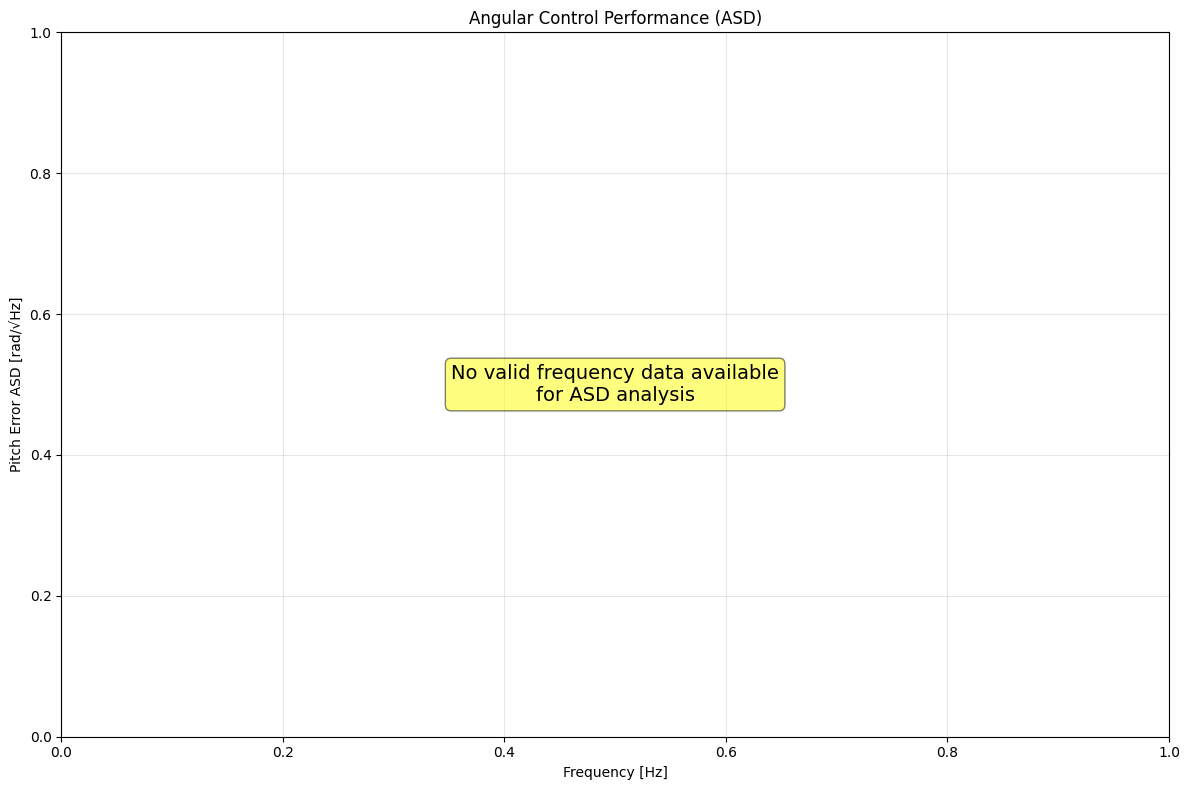

In [17]:
def plot_asd_performance(rollout_data, analysis_results, save_path=None):
    """Plot Amplitude Spectral Density (ASD) - standard for LIGO analysis."""
    
    # Compute ASD from PSD (square root)
    freqs = analysis_results['frequencies']
    psd = analysis_results['pitch_psd']
    
    # Debug information with safe array operations
    print(f"Debug: Total frequencies: {len(freqs)}")
    if len(freqs) > 0:
        positive_freqs = freqs > 0
        print(f"Debug: Positive frequencies: {np.sum(positive_freqs)}")
        if len(psd) > 0:
            print(f"Debug: PSD shape: {psd.shape}, PSD range: [{np.min(psd):.2e}, {np.max(psd):.2e}]")
        else:
            print(f"Debug: PSD shape: {psd.shape}, PSD is empty")
    else:
        print("Debug: No frequency data available")
        positive_freqs = np.array([])
    
    # Check if we have valid frequency data
    if not np.any(positive_freqs) or len(freqs[positive_freqs]) == 0:
        print("Warning: No valid frequency data available for ASD analysis")
        # Create empty plot with message
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.text(0.5, 0.5, 'No valid frequency data available\nfor ASD analysis', 
               ha='center', va='center', transform=ax.transAxes, fontsize=14,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Pitch Error ASD [rad/√Hz]')
        ax.set_title('Angular Control Performance (ASD)')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        return
    
    # ASD = sqrt(PSD)
    asd = np.sqrt(psd[positive_freqs])
    freqs_pos = freqs[positive_freqs]
    
    # More debug information with safe operations
    if len(asd) > 0:
        print(f"Debug: ASD shape: {asd.shape}, ASD range: [{np.min(asd):.2e}, {np.max(asd):.2e}]")
        print(f"Debug: Freq range: [{np.min(freqs_pos):.3f}, {np.max(freqs_pos):.3f}] Hz")
    else:
        print(f"Debug: ASD shape: {asd.shape}, ASD is empty")
        print(f"Debug: No frequency data available")
    
    # Check for valid ASD data
    valid_asd_mask = np.isfinite(asd) & (asd > 0)
    if not np.any(valid_asd_mask):
        print("Warning: No valid ASD data (all zeros or infinite values)")
        return
        
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Filter out invalid data for plotting
    plot_freqs = freqs_pos[valid_asd_mask]
    plot_asd = asd[valid_asd_mask]
    
    print(f"Debug: Plotting {len(plot_freqs)} valid ASD points")
    
    # Main ASD plot
    if len(plot_freqs) > 0:
        try:
            axes[0, 0].loglog(plot_freqs, plot_asd, 'b-', linewidth=1.5, label='Pitch Error ASD')
        except Exception as e:
            print(f"Warning: loglog plotting failed: {e}")
            print("Falling back to linear scale")
            axes[0, 0].plot(plot_freqs, plot_asd, 'b-', linewidth=1.5, label='Pitch Error ASD')
            axes[0, 0].set_yscale('log')
            axes[0, 0].set_xscale('log')
    else:
        print("Warning: No valid data points to plot")
    
    # Add LIGO target levels for reference
    axes[0, 0].axhline(y=1e-9, color='r', linestyle='--', alpha=0.7, label='LIGO Target (1 nrad/√Hz)')
    axes[0, 0].axhline(y=1e-10, color='g', linestyle='--', alpha=0.7, label='Advanced Target (0.1 nrad/√Hz)')
    
    # Highlight frequency bands from reward function (with safe max calculation)
    max_freq = freqs_pos.max() if len(freqs_pos) > 0 else 128.0
    safe_max_freq = min(128.0, max_freq) if max_freq > 0 else 128.0
    axes[0, 0].axvspan(0.1, 3, alpha=0.15, color='red', label='Low Band (<3Hz)')
    axes[0, 0].axvspan(8, 30, alpha=0.15, color='orange', label='Mid Band (8-30Hz)')
    axes[0, 0].axvspan(40, safe_max_freq, alpha=0.15, color='purple', label='High Band (>40Hz)')
    
    axes[0, 0].set_xlabel('Frequency [Hz]')
    axes[0, 0].set_ylabel('Pitch Error ASD [rad/√Hz]')
    axes[0, 0].set_title('Angular Control Performance (ASD)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Let matplotlib auto-scale both axes to show all data
    print(f"Debug: Letting matplotlib auto-scale both axes")
    
    # Time series
    time = analysis_results['time']
    axes[0, 1].plot(time, rollout_data['pitch_errors'], 'b-', linewidth=1)
    axes[0, 1].set_xlabel('Time [s]')
    axes[0, 1].set_ylabel('Pitch Error [µrad]')
    axes[0, 1].set_title(f'Time Series (RMS: {analysis_results["rms_error_urad"]:.2f} µrad)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Frequency band RMS analysis with better error handling
    band_powers = []
    band_labels = ['Low (<3Hz)', 'Mid (8-30Hz)', 'High (>40Hz)']
    
    # Low band
    low_mask = (freqs_pos >= 0.1) & (freqs_pos < 3.0)
    if np.any(low_mask) and len(psd[positive_freqs][low_mask]) > 0:
        low_rms = np.sqrt(np.trapz(psd[positive_freqs][low_mask], freqs_pos[low_mask]))
    else:
        low_rms = 0.0
    
    # Mid band  
    mid_mask = (freqs_pos >= 8.0) & (freqs_pos <= 30.0)
    if np.any(mid_mask) and len(psd[positive_freqs][mid_mask]) > 0:
        mid_rms = np.sqrt(np.trapz(psd[positive_freqs][mid_mask], freqs_pos[mid_mask]))
    else:
        mid_rms = 0.0
    
    # High band
    safe_high_freq = min(128.0, max_freq) if max_freq > 0 else 128.0
    high_mask = (freqs_pos > 40.0) & (freqs_pos <= safe_high_freq)
    if np.any(high_mask) and len(psd[positive_freqs][high_mask]) > 0:
        high_rms = np.sqrt(np.trapz(psd[positive_freqs][high_mask], freqs_pos[high_mask]))
    else:
        high_rms = 0.0
    
    band_powers = [low_rms * 1e9, mid_rms * 1e9, high_rms * 1e9]  # Convert to nrad
    
    # Handle case where all band powers are zero for log scale
    if all(p == 0.0 for p in band_powers):
        band_powers = [1e-3, 1e-3, 1e-3]  # Small non-zero values for plotting
    
    axes[1, 0].bar(band_labels, band_powers, color=['red', 'orange', 'purple'], alpha=0.7)
    axes[1, 0].set_ylabel('RMS Error [nrad]')
    axes[1, 0].set_title('Frequency Band Performance')
    axes[1, 0].grid(True, alpha=0.3)
    try:
        axes[1, 0].set_yscale('log')
    except:
        # Fallback to linear scale if log scale fails
        pass
    
    # Control signal analysis
    axes[1, 1].plot(time, rollout_data['control_signals'], 'r-', linewidth=1)
    axes[1, 1].set_xlabel('Time [s]')
    axes[1, 1].set_ylabel('Control Signal [-1, 1]')
    axes[1, 1].set_title(f'Control Effort (RMS: {analysis_results["control_effort_rms"]:.3f})')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"ASD performance plot saved to: {save_path}")
    
    plt.show()
    
    # Print performance summary (with safety checks)
    print("\n" + "="*60)
    print("LIGO ASC PERFORMANCE SUMMARY")
    print("="*60)
    print(f"Overall RMS Error:     {analysis_results['rms_error_urad']:.2f} µrad")
    print(f"Low Band RMS (<3Hz):   {band_powers[0]:.2f} nrad")  
    print(f"Mid Band RMS (8-30Hz): {band_powers[1]:.2f} nrad")
    print(f"High Band RMS (>40Hz): {band_powers[2]:.2f} nrad")
    print(f"Control Effort RMS:    {analysis_results['control_effort_rms']:.3f}")
    print(f"Episode Reward:        {analysis_results['episode_reward']:.4f}")
    print("="*60)
    
    # Performance assessment (with safer band power evaluation)
    # Convert back from nrad to actual values for comparison
    actual_low = band_powers[0] / 1e9 if band_powers[0] > 1e-3 else 0.0  
    actual_mid = band_powers[1] / 1e9 if band_powers[1] > 1e-3 else 0.0
    actual_high = band_powers[2] / 1e9 if band_powers[2] > 1e-3 else 0.0
    
    if actual_low < 1e-9 and actual_mid < 1e-10 and actual_high < 1e-11:
        print("🟢 EXCELLENT: All frequency bands meet advanced LIGO targets!")
    elif actual_low < 1e-8 and actual_mid < 1e-9 and actual_high < 1e-10:
        print("🟡 GOOD: Performance within LIGO operational targets")
    else:
        print("🔴 NEEDS IMPROVEMENT: Performance below LIGO requirements")
    print("="*60)


def comprehensive_evaluation(env, agent, num_episodes=10, max_steps=2000):
    """Comprehensive evaluation with ASD analysis."""
    
    print("Starting comprehensive evaluation...")
    all_rollouts = []
    episode_rewards = []
    
    for i in tqdm(range(num_episodes), desc="Evaluation episodes"):
        rollout = detailed_rollout(env, agent, max_steps=max_steps, deterministic=True)
        analysis = performance_analysis(rollout)
        
        all_rollouts.append((rollout, analysis))
        episode_rewards.append(rollout['episode_reward'])
        
        print(f"Episode {i+1}: Reward={rollout['episode_reward']:.3f}, RMS={analysis['rms_error_urad']:.2f} µrad")
    
    # Aggregate statistics
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    
    print(f"\nEvaluation Summary:")
    print(f"Mean Episode Reward: {mean_reward:.3f} ± {std_reward:.3f}")
    print(f"Best Episode: {np.max(episode_rewards):.3f}")
    print(f"Worst Episode: {np.min(episode_rewards):.3f}")
    
    # Plot best performing episode
    best_idx = np.argmax(episode_rewards)
    best_rollout, best_analysis = all_rollouts[best_idx]
    
    print(f"\nPlotting best episode performance (Episode {best_idx+1}):")
    plot_asd_performance(best_rollout, best_analysis)
    
    return all_rollouts, {
        'mean_reward': mean_reward,
        'std_reward': std_reward,
        'episode_rewards': episode_rewards
    }

plot_asd_performance(test_rollout, test_analysis)

## Post-Training Evaluation

After training completes, use these functions for comprehensive performance analysis:

=== POST-TRAINING EVALUATION ===
Run this cell after training to get detailed ASD analysis
Starting comprehensive evaluation...


Evaluation episodes: 100%|██████████| 5/5 [00:00<00:00, 124.39it/s]

Episode 1: Reward=0.000, RMS=0.15 µrad
Episode 2: Reward=0.000, RMS=0.15 µrad
Episode 3: Reward=0.000, RMS=0.15 µrad
Episode 4: Reward=0.000, RMS=0.15 µrad
Episode 5: Reward=0.000, RMS=0.15 µrad

Evaluation Summary:
Mean Episode Reward: 0.000 ± 0.000
Best Episode: 0.000
Worst Episode: 0.000

Plotting best episode performance (Episode 2):
Debug: Total frequencies: 0
Debug: No frequency data available


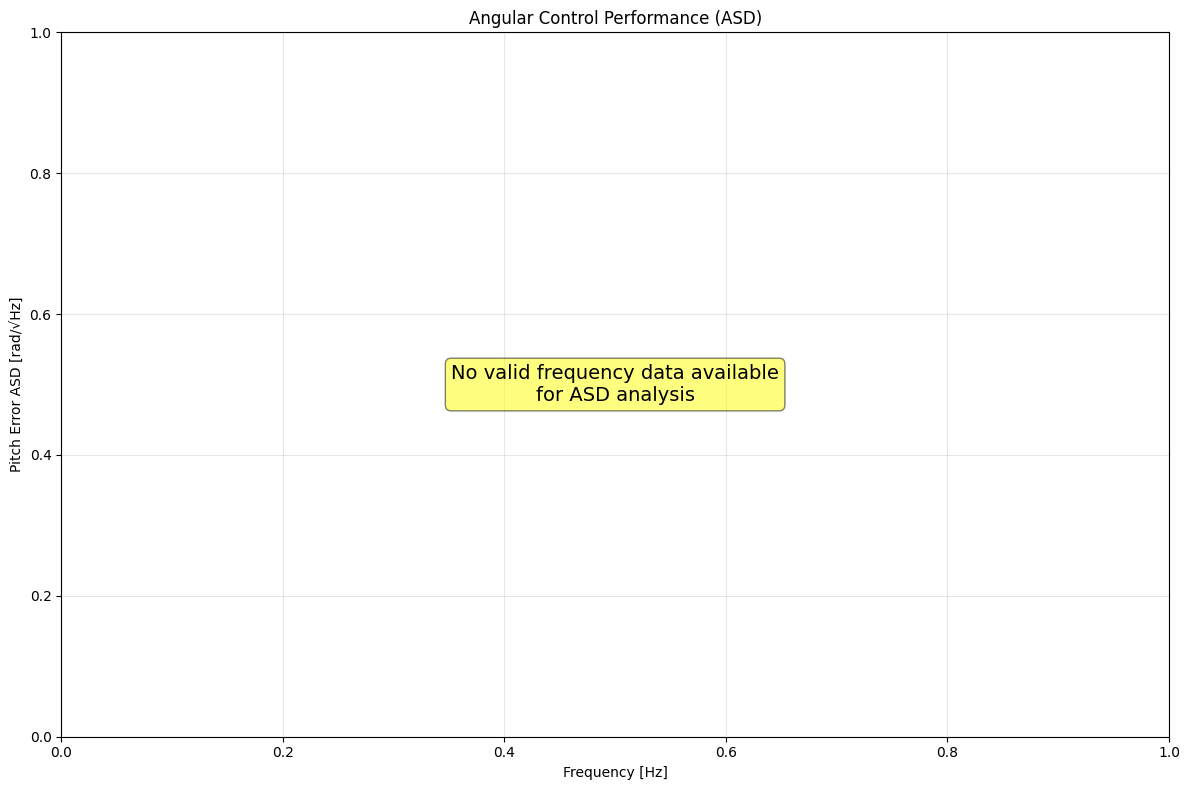

Training progress plot saved to: /Users/arushpimpalkar/work/timepass/RL_Arush/outputs/plots/training_progress.png


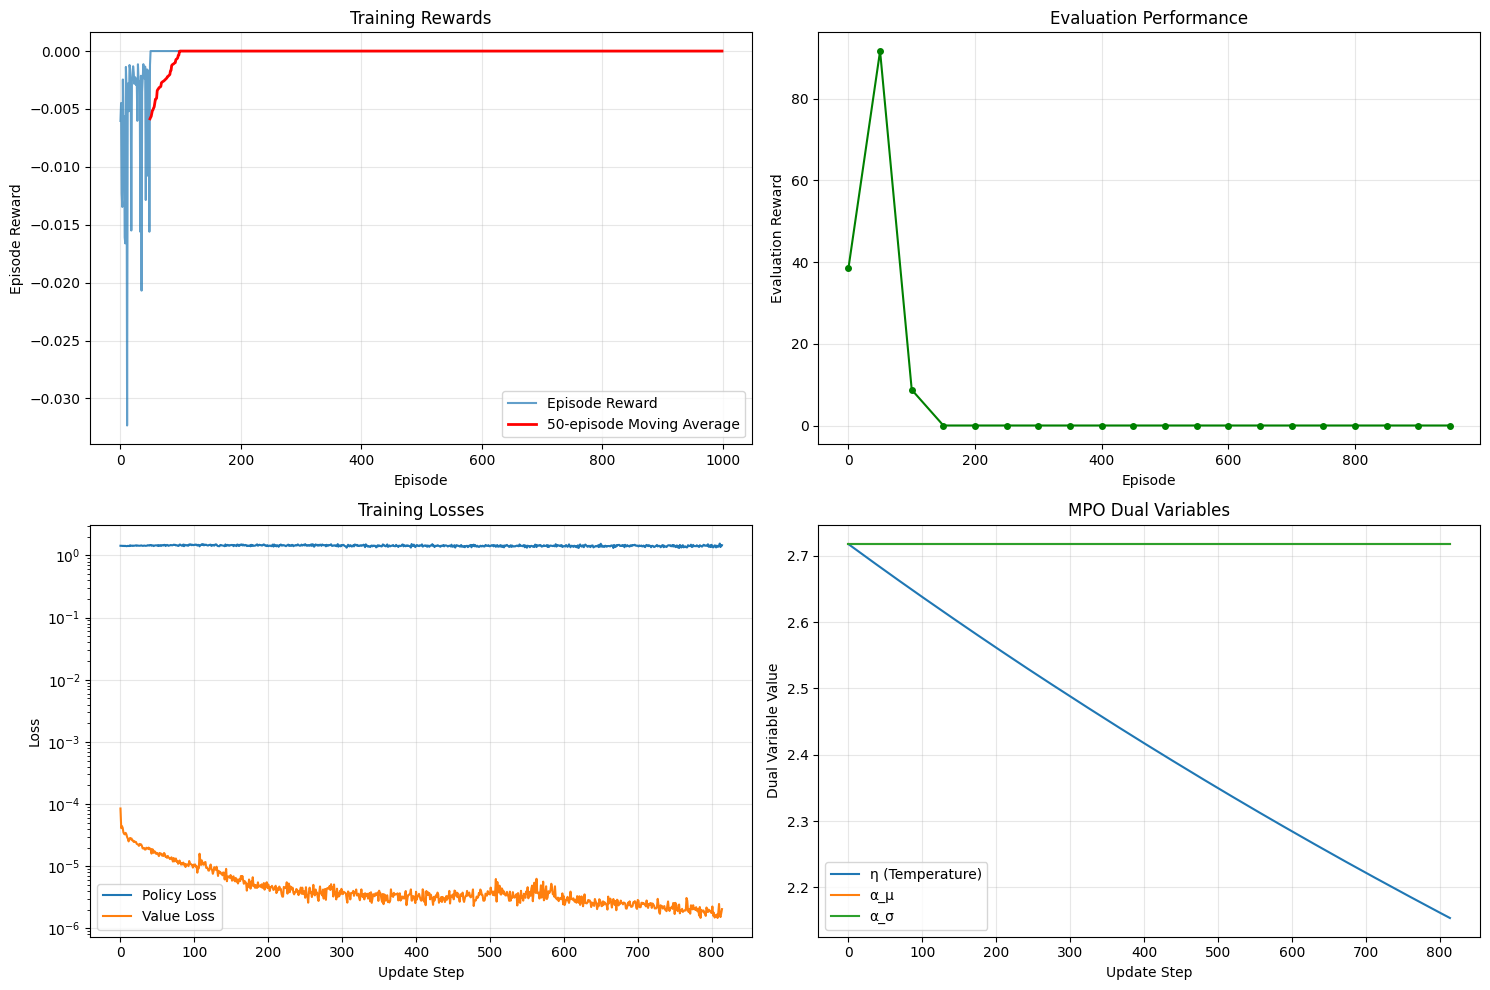


Evaluation completed! Check the ASD plots above for performance assessment.


In [18]:
# After training completes, run comprehensive evaluation
print("=== POST-TRAINING EVALUATION ===")
print("Run this cell after training to get detailed ASD analysis")

# Comprehensive evaluation with multiple episodes
eval_rollouts, eval_stats = comprehensive_evaluation(env, agent, num_episodes=5, max_steps=2000)

# Plot training progress
if 'training_metrics' in locals():
    plot_training_progress(training_metrics, 
                          save_path='/Users/arushpimpalkar/work/timepass/RL_Arush/outputs/plots/training_progress.png')

print("\nEvaluation completed! Check the ASD plots above for performance assessment.")

=== DEBUGGING ASD PLOT ISSUE ===

Step 1: Running fresh test rollout...
Rollout completed: 2 steps
Pitch errors shape: (2,)
Pitch error range: [-3.35e-01, 0.00e+00]

Step 2: Running performance analysis with debug...

Step 3: Attempting to plot ASD with debug output...
Debug: Total frequencies: 0
Debug: No frequency data available


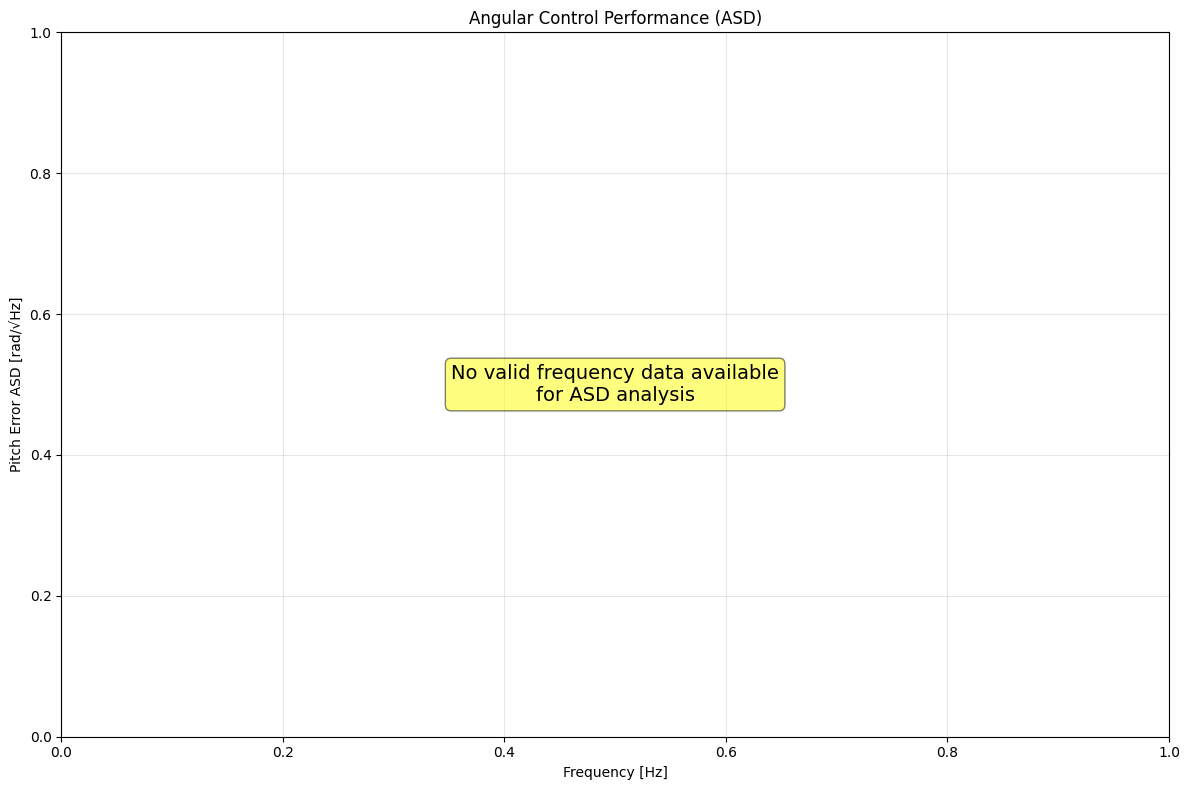


=== DEBUG COMPLETE ===


In [15]:
# Debug: Run test rollout with detailed debugging
print("=== DEBUGGING ASD PLOT ISSUE ===")
print("\nStep 1: Running fresh test rollout...")

# Run a fresh test rollout with debug output
test_rollout_debug = detailed_rollout(env, agent, max_steps=500, deterministic=True)
print(f"Rollout completed: {test_rollout_debug['episode_length']} steps")
print(f"Pitch errors shape: {test_rollout_debug['pitch_errors'].shape}")
print(f"Pitch error range: [{np.min(test_rollout_debug['pitch_errors']):.2e}, {np.max(test_rollout_debug['pitch_errors']):.2e}]")

print("\nStep 2: Running performance analysis with debug...")
test_analysis_debug = performance_analysis(test_rollout_debug)

print("\nStep 3: Attempting to plot ASD with debug output...")
plot_asd_performance(test_rollout_debug, test_analysis_debug)

print("\n=== DEBUG COMPLETE ===")

=== COMPARING SIMPLE vs FREQUENCY-BAND REWARDS ===

Setting up environments...
Creating agents...

Quick training - 50 episodes each...
Training frequency-band agent...
Training simple agent...

Generating evaluation rollouts...

Generating ASD comparison plot...


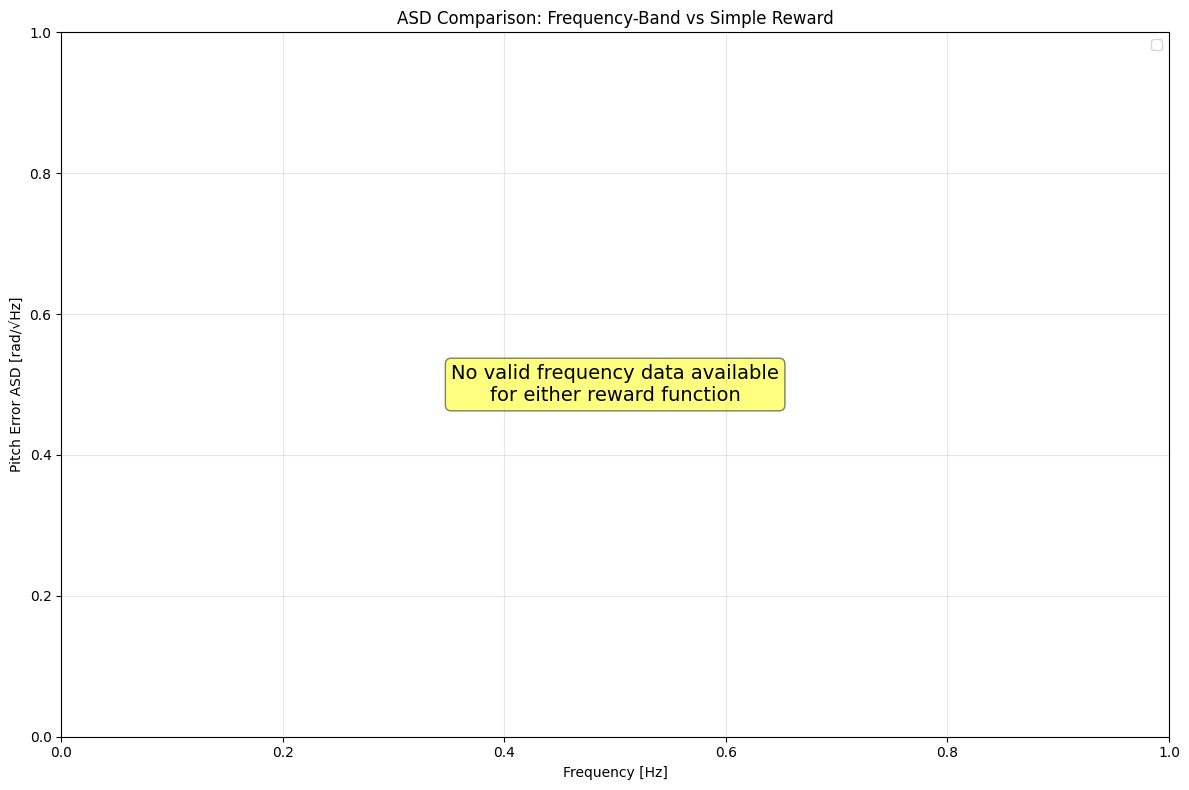


PERFORMANCE COMPARISON
Frequency-Band Reward:
  RMS Error: 0.15 µrad
  Episode Reward: 0.0000

Simple Reward:
  RMS Error: 0.34 µrad
  Episode Reward: -2.7737


In [16]:
# Simple Reward vs Frequency-Band Reward Comparison
print("=== COMPARING SIMPLE vs FREQUENCY-BAND REWARDS ===")

# Simple reward wrapper
class SimpleRewardWrapper(gym.Wrapper):
    def reward(self, obs, action, info):
        # Simple negative absolute error reward
        pitch_error = obs[0]  # Current pitch error [µrad]
        control_effort = action[0] if hasattr(action, '__len__') else action
        return -np.abs(pitch_error) - 0.01 * abs(control_effort)
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        custom_reward = self.reward(obs, action, info)
        return obs, custom_reward, terminated, truncated, info

# Create environments with different rewards
print("\nSetting up environments...")
# Environment 1: Frequency-band reward (already created)
env_freq = env  # Current frequency-band reward environment

# Environment 2: Simple reward  
try:
    env_simple_base = LIGOASCEnvEnhanced()
except:
    from rl_arush.envs.ligo_asc_env import LIGOASCEnv
    env_simple_base = LIGOASCEnv()
env_simple = SimpleRewardWrapper(env_simple_base)

# Create agents
print("Creating agents...")
agent_freq = agent  # Current agent with frequency reward
agent_simple = MPOAgent(obs_dim, action_dim, **mpo_config)

# Quick training (50 episodes each)
print("\nQuick training - 50 episodes each...")

# Train frequency-band agent
print("Training frequency-band agent...")
freq_buffer = ReplayBuffer(10000)
for ep in range(50):
    experiences, _, _ = collect_episode(env_freq, agent_freq, max_steps=200)
    for exp in experiences:
        freq_buffer.push(*exp)
    if len(freq_buffer) >= 64:
        batch = freq_buffer.sample(64)
        agent_freq.update(batch)

# Train simple agent  
print("Training simple agent...")
simple_buffer = ReplayBuffer(10000)
for ep in range(50):
    experiences, _, _ = collect_episode(env_simple, agent_simple, max_steps=200)
    for exp in experiences:
        simple_buffer.push(*exp)
    if len(simple_buffer) >= 64:
        batch = simple_buffer.sample(64)
        agent_simple.update(batch)

# Generate evaluation rollouts
print("\nGenerating evaluation rollouts...")
rollout_freq = detailed_rollout(env_freq, agent_freq, max_steps=1000, deterministic=True)
analysis_freq = performance_analysis(rollout_freq)

rollout_simple = detailed_rollout(env_simple, agent_simple, max_steps=1000, deterministic=True)
analysis_simple = performance_analysis(rollout_simple)

# ASD Comparison Plot
print("\nGenerating ASD comparison plot...")
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Initialize variables to track if we have valid data
has_freq_data = False
has_simple_data = False
max_freq_combined = 128.0

# Frequency-band reward ASD
freqs_freq = analysis_freq['frequencies']
psd_freq = analysis_freq['pitch_psd']
if len(freqs_freq) > 0:
    pos_freq = freqs_freq > 0
    if np.any(pos_freq):
        asd_freq = np.sqrt(psd_freq[pos_freq])
        freqs_pos_freq = freqs_freq[pos_freq]
        valid_mask_freq = np.isfinite(asd_freq) & (asd_freq > 0)
        if np.any(valid_mask_freq):
            ax.loglog(freqs_pos_freq[valid_mask_freq], asd_freq[valid_mask_freq], 
                     'b-', linewidth=2, label='Frequency-Band Reward')
            has_freq_data = True
            max_freq_combined = max(max_freq_combined, freqs_pos_freq.max())

# Simple reward ASD
freqs_simple = analysis_simple['frequencies']
psd_simple = analysis_simple['pitch_psd']
if len(freqs_simple) > 0:
    pos_simple = freqs_simple > 0
    if np.any(pos_simple):
        asd_simple = np.sqrt(psd_simple[pos_simple])
        freqs_pos_simple = freqs_simple[pos_simple]
        valid_mask_simple = np.isfinite(asd_simple) & (asd_simple > 0)
        if np.any(valid_mask_simple):
            ax.loglog(freqs_pos_simple[valid_mask_simple], asd_simple[valid_mask_simple], 
                     'r-', linewidth=2, label='Simple Reward')
            has_simple_data = True
            max_freq_combined = max(max_freq_combined, freqs_pos_simple.max())

# Only show targets and bands if we have some data
if has_freq_data or has_simple_data:
    # LIGO targets
    ax.axhline(y=1e-9, color='gray', linestyle='--', alpha=0.7, label='LIGO Target (1 nrad/√Hz)')
    ax.axhline(y=1e-10, color='gray', linestyle=':', alpha=0.7, label='Advanced Target (0.1 nrad/√Hz)')

    # Frequency bands
    ax.axvspan(0.1, 3, alpha=0.1, color='red', label='Low Band (<3Hz)')
    ax.axvspan(8, 30, alpha=0.1, color='orange', label='Mid Band (8-30Hz)')
    ax.axvspan(40, max_freq_combined, alpha=0.1, color='purple', label='High Band (>40Hz)')
else:
    # No valid data to plot
    ax.text(0.5, 0.5, 'No valid frequency data available\nfor either reward function', 
           ha='center', va='center', transform=ax.transAxes, fontsize=14, 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Pitch Error ASD [rad/√Hz]')
ax.set_title('ASD Comparison: Frequency-Band vs Simple Reward')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"Frequency-Band Reward:")
print(f"  RMS Error: {analysis_freq['rms_error_urad']:.2f} µrad")
print(f"  Episode Reward: {rollout_freq['episode_reward']:.4f}")
print()
print(f"Simple Reward:")
print(f"  RMS Error: {analysis_simple['rms_error_urad']:.2f} µrad") 
print(f"  Episode Reward: {rollout_simple['episode_reward']:.4f}")
print("="*60)

## 10. Quick Start Instructions

**To use this notebook:**

1. **First time setup**: Run cells 1-4 to import libraries and initialize the environment
2. **Implement reward**: Modify the `CustomRewardWrapper.reward()` method in cell 6
3. **Start training**: Uncomment the training line in cell 8 
4. **Monitor progress**: Training metrics are automatically logged and plotted
5. **Evaluate results**: Use the rollout functions to test trained agents

**Key Features:**
- ✅ Enhanced 15-dimensional observation space with seismic information
- ✅ MPO algorithm implementation with proper dual variable optimization  
- ✅ Comprehensive training and evaluation pipeline
- ✅ Automatic checkpointing and metric logging
- ✅ Detailed performance analysis and visualization

**Files Created During Training:**
- Model checkpoints: `outputs/models/mpo_checkpoint_ep*.pkl`
- Training plots: `outputs/plots/training_progress.png`
- Performance analysis: `outputs/plots/control_performance.png`

## Enhanced 15-Dimensional Observation Space Explained

The enhanced environment provides **15 observation parameters** instead of the original 8:

### **Original 8 Parameters (indices 0-7):**
- **[0]** Current pitch error [µrad] - Real-time angular deviation
- **[1]** Previous pitch error [µrad] - One timestep history
- **[2]** Observation band error [µrad] - Filtered error (0.1-10 Hz)
- **[3]** Control band error [µrad] - Control-relevant frequency band
- **[4-7]** Control history - Last 4 control actions applied

### **New 7 Seismic Parameters (indices 8-14):**
- **[8]** Raw seismic force [µN] - Unfiltered disturbance magnitude
- **[9]** Low frequency seismic [µN] - 0.1-1 Hz band (tilt/microseism)
- **[10]** Mid frequency seismic [µN] - 1-8 Hz band (traffic/machinery)
- **[11]** High frequency seismic [µN] - 8-30 Hz band (local vibrations)
- **[12]** Seismic velocity [µN/s] - Rate of change for trend detection
- **[13]** Seismic acceleration [µN/s²] - Second derivative for dynamics
- **[14]** Seismic RMS [µN] - Rolling window power estimation

This **feed-forward information** allows the RL agent to anticipate disturbances and apply predictive control, similar to LIGO's actual seismic isolation systems.